In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib notebook


from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
n_pixels = 28*28
latent_dim = 20
h_dim = 512

X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [3]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

In [4]:
#Encoder
with tf.name_scope('Encoder'):
    with tf.name_scope('Layer_1'):
        W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
        b_enc = bias_variable([h_dim], 'b_enc')
        h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

    with tf.name_scope('Layer_2'):
        W_mu = weight_variable([h_dim, latent_dim], 'W_enc')
        b_mu = bias_variable([latent_dim], 'b_enc')
        mu = FC_layer(h_enc, W_mu, b_mu)

In [5]:
#Latent Space
with tf.name_scope('Latent_Space'):   
    with tf.name_scope('Log_Std'):
        W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
        b_logstd = bias_variable([latent_dim], 'b_logstd')
        logstd = FC_layer(h_enc, W_logstd, b_logstd)
    
    with tf.name_scope('Z'):
        noise = tf.random_normal([1, latent_dim])
        z = mu + tf.multiply(noise, tf.exp(.5*logstd))

        tf.summary.histogram('mu', mu)
        tf.summary.histogram('z', z)
        tf.summary.histogram('W_logstd', W_logstd)

In [6]:
#Decoder
with tf.name_scope('Decoder'):
    with tf.name_scope('Layer_1'):
        W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
        b_dec = bias_variable([h_dim], 'b_dec')
        h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))
    
    with tf.name_scope('Layer_2'):
        W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
        b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
        reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

In [7]:
#Loss Function
with tf.name_scope('Loss_Function'):
    log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)\
                                   *tf.log(1 -reconstruction + 1e-9), \
                                   reduction_indices=1)
    KL_term = -.5*tf.reduce_sum(1 + 2 *logstd - tf.pow(mu,2) - tf.exp(2*logstd),\
                               reduction_indices=1)
    variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
    optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)
    
    KL_mean = tf.reduce_mean(KL_term)
    LogL_mean = tf.reduce_mean(log_likelihood)
    VLB_mean = tf.reduce_mean(variational_lower_bound)
    tf.summary.scalar('Log_Likelihood', LogL_mean)
    tf.summary.scalar('KL_term', KL_mean)
    tf.summary.scalar('Variational_Lower_Bound', VLB_mean)
    

In [8]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
writer = tf.summary.FileWriter('./train', sess.graph)
sess.run(init)

In [11]:
epochs = 10000
batch_size = 1024

for i in range(epochs):
    x_batch = np.round(mnist.train.next_batch(batch_size)[0])
    merged = tf.summary.merge_all()
    opt, summary, vlb_eval = sess.run((optimizer, merged, variational_lower_bound), feed_dict={X: x_batch})
    print("Iteration: {}, Loss: {}".format(i, vlb_eval), end='\r')
    writer.add_summary(summary, i)

<IPython.core.display.Javascript object>


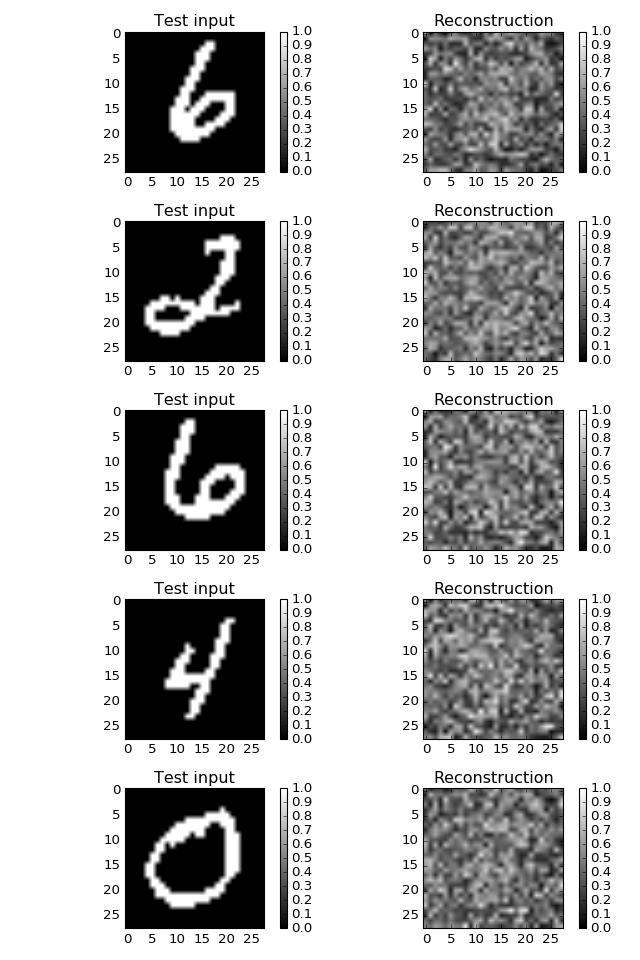

In [38]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

batch_size = 1024
x_batch = mnist.train.next_batch(batch_size)
x_batch, y_batch = np.round(x_batch[0]), x_batch[1]

# x_reconstruct = vae.reconstruct(x_sample)
x_reconstruct = reconstruction.eval(feed_dict={X: x_batch})
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_batch[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


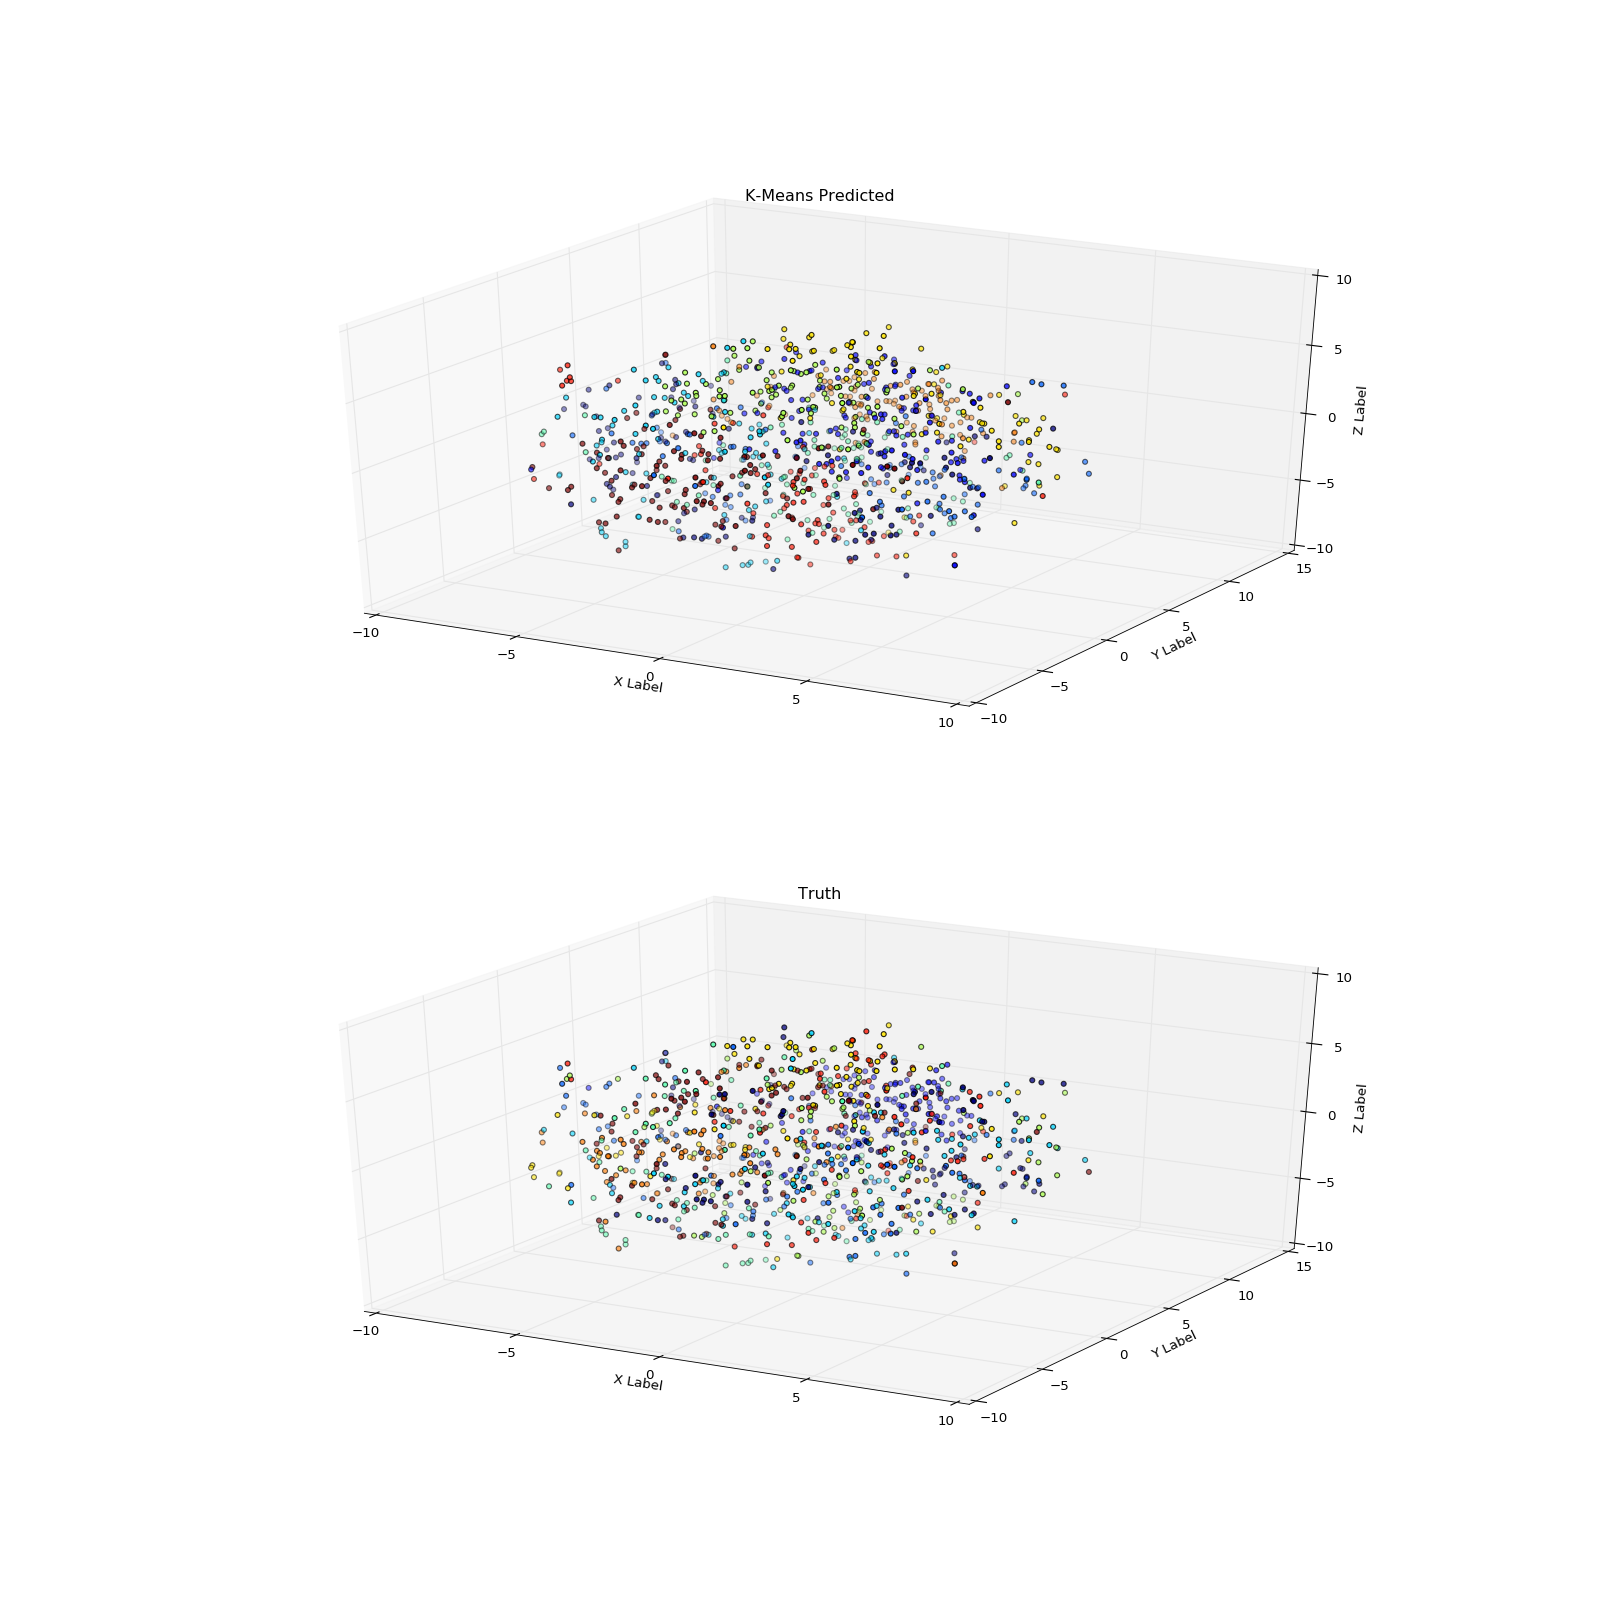

In [37]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(mu.eval(feed_dict={X: x_batch}))
kpred_labels = kmeans.labels_

#reduce demensions for plotting.
model = TSNE(n_components=3, random_state=0, perplexity=50, learning_rate=500, n_iter=280)
z_mu = model.fit_transform(mu.eval(feed_dict={X: x_batch}))

fig = plt.figure(2, figsize=(20,20))
bx = fig.add_subplot(212, projection='3d')
kx = fig.add_subplot(211, projection='3d')


xs = z_mu[:, 0]
ys = z_mu[:, 1]
zs = z_mu[:, 2]

bx.scatter(xs, ys, zs, c=np.argmax(y_batch, 1))
kx.scatter(xs, ys, zs, c=np.array(kpred_labels))
bx.set_xlabel('X Label')
bx.set_ylabel('Y Label')
bx.set_zlabel('Z Label')
bx.set_title('Truth')
kx.set_xlabel('X Label')
kx.set_ylabel('Y Label')
kx.set_zlabel('Z Label')
kx.set_title('K-Means Predicted')
plt.show()